In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression

In [2]:
X_full, y_full = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(len(X_full))

70000


In [3]:
print(len(y_full[y_full=='9']))

6958


In [4]:
nines_idx = y_full == '9'

In [6]:
X_positive = X_full[nines_idx]
y_positive = y_full[nines_idx]

X_negative = X_full[np.invert(nines_idx)]
y_negative = y_full[np.invert(nines_idx)]

In [7]:
print(len(X_positive))
print(len(X_negative))

6958
63042


In [8]:
print(Counter(y_positive).most_common())
print(Counter(y_negative).most_common())

[('9', 6958)]
[('1', 7877), ('7', 7293), ('3', 7141), ('2', 6990), ('0', 6903), ('6', 6876), ('8', 6825), ('4', 6824), ('5', 6313)]


In [9]:
np.random.permutation(len(X_negative))

array([ 1710, 57608, 38026, ...,  2175, 13896, 62178])

In [9]:
permutation = np.random.permutation(len(X_negative))[:len(X_positive)]
X_negative = X_negative[permutation]
y_negative = y_negative[permutation]

In [10]:
print(Counter(y_positive).most_common())
print(Counter(y_negative).most_common())

[('9', 6958)]
[('1', 7877), ('7', 7293), ('3', 7141), ('2', 6990), ('0', 6903), ('6', 6876), ('8', 6825), ('4', 6824), ('5', 6313)]


In [11]:
X = np.concatenate((X_positive, X_negative))
y = np.concatenate((np.ones(len(X_positive)), np.zeros(len(X_negative))))
permutation = np.random.permutation(len(X))
X = X[permutation]
y = y[permutation]

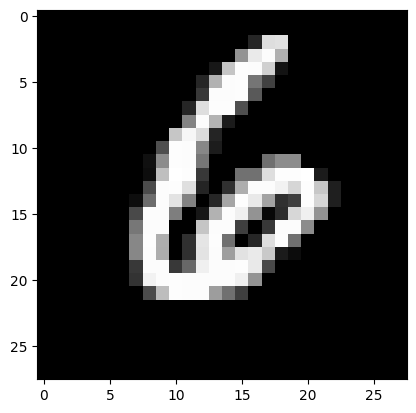

In [12]:
plt.imshow(X_negative[12].reshape(28,28), cmap='gray')
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_test, X_calib, y_test, y_calib = train_test_split(X_test, y_test, train_size=0.5)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_calib = scaler.transform(X_calib)

In [85]:
def plot_calibration(clf, X, y, save_calibration_model=False, calibration_model_name=None):
    def plot_calibration_curve(ground_truth, probs, title):
        calib_prob_true, calib_prob_pred = calibration_curve(ground_truth, probs, n_bins=10)
        brier_score = brier_score_loss(ground_truth, new_probs)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.plot(*zip(*sorted(zip(*(calib_prob_true, calib_prob_pred)))), marker='.', color='orange')
        plt.title(f'{title}\nBrier score: {round(brier_score, 4)}')
        
    if hasattr(clf, "predict_proba"):
        overlay_probs = clf.predict_proba(X)[:, 1]
    else:  # use decision function
        overlay_probs = clf.decision_function(X)
        overlay_probs = (overlay_probs - overlay_probs.min()) / (overlay_probs.max() - overlay_probs.min())
    ground_truth = y
    prob_true, prob_pred = calibration_curve(ground_truth, overlay_probs, n_bins=10)
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(hspace=0.4) 

    plt.subplot(3,2,1)
    brier_score = brier_score_loss(ground_truth, overlay_probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(prob_pred, prob_true, marker='.', color='orange')
    plt.title(f'Before calibration\nBrier score: {round(brier_score, 4)}')
    
    plt.subplot(3,2,3)
    prob_pred_calib, alpha, beta = platt_scaling(prob_pred, prob_true)
    plt.plot([0, 1], [0, 1], alpha=0)
    plt.plot(prob_pred, prob_true, marker='.', color='orange')
    plt.plot(prob_pred, prob_pred_calib, color='red')
    plt.title(f'Fitted logistic regression')
    
    plt.subplot(3,2,4)
    new_probs = 1 / (1 + np.exp(alpha * np.array(overlay_probs) + beta))
    plot_calibration_curve(ground_truth, new_probs, 'After calibration with Platt scaling')
    
    plt.subplot(3,2,5)
    isotonic_model = isotonic_regression(prob_pred, prob_true)
    if save_calibration_model:
        os.makedirs('model', exist_ok=True)
        if not calibration_model_name:
            calibration_model_name = model.model_id + "_calibration"
        model_path = f'model/{calibration_model_name}.pmml'
        isotonic2pmml.topmml(isotonic = model, 
                         datafield_name = 'probability', 
                         targetfield_name = 'calibrated_probablity', 
                         outputfile = model_path, 
                         xs=prob_pred, 
                         ys=isotonic_model.transform(prob_pred))
        print(f"Saved calibration model at {model_path}")

    plt.plot([0, 1], [0, 1], alpha=0)
    plt.plot(prob_pred, prob_true, marker='.', color='orange')
    plt.plot(isotonic_model.X_thresholds_, isotonic_model.y_thresholds_, color='red')
    plt.title(f'Fitted isotonic regression')
    
    plt.subplot(3,2,6)
    new_probs = isotonic_model.predict(overlay_probs)
    plot_calibration_curve(ground_truth, new_probs, 'After calibration with isotonic regression')
    plt.show()

def platt_scaling(prob_pred, prob_true):
    print(prob_pred, prob_true)
    prob_pred_2, prob_true_2 = list(zip(*[p for p in zip(prob_pred, prob_true) if 0<p[1]<1]))
    prob_true_2 = np.log((1 / np.array(prob_true_2)) - 1)
    prob_pred_2= np.array(prob_pred_2)
    model = LinearRegression().fit(prob_pred_2.reshape(-1, 1), prob_true_2.reshape(-1, 1))
    alpha = model.coef_[0, 0]
    beta = model.predict([[0]])[0, 0]
    return 1 / (1 + np.exp(alpha * np.array(prob_pred) + beta)), alpha, beta

def isotonic_regression(prob_pred, prob_true):
    return IsotonicRegression(out_of_bounds='clip').fit(prob_pred, prob_true)

[0.01584675 0.14363333 0.25071429 0.35050847 0.45333333 0.56196721
 0.65960526 0.75662791 0.86302158 0.95636771] [0.00203424 0.04666667 0.13392857 0.27118644 0.64444444 0.83606557
 0.97368421 0.98837209 1.         1.        ]


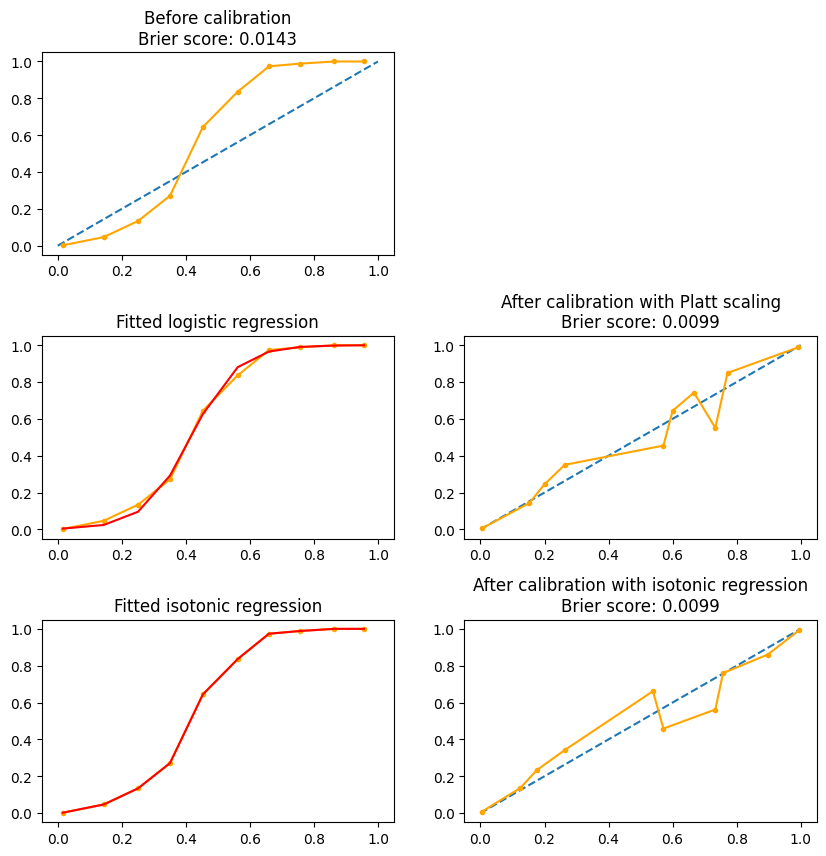

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.neural_network import MLPClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
plot_calibration(clf, X_calib, y_calib)

[2.43173805e-04 1.63181435e-01 2.31159156e-01 3.64555007e-01
 4.45144004e-01 5.77024579e-01 6.70435874e-01 7.58141520e-01
 8.68135024e-01 9.97770919e-01] [0.00363636 0.28571429 0.16666667 0.25       0.57142857 0.33333333
 0.25       0.4        0.44444444 0.98253968]


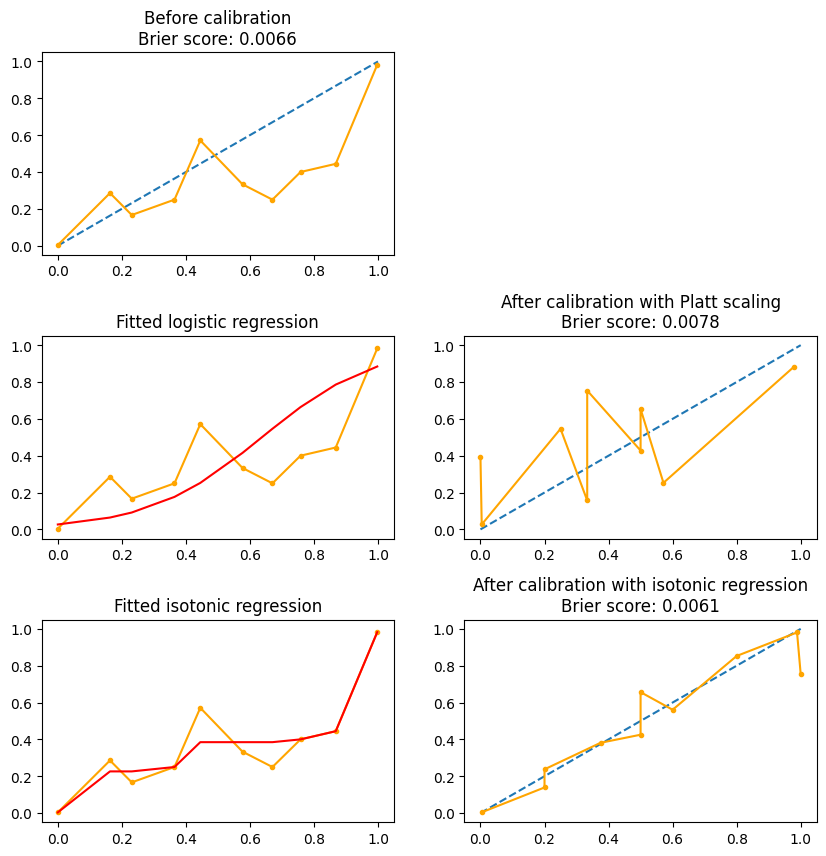

In [93]:
clf = MLPClassifier()
clf.fit(X_train, y_train)
plot_calibration(clf, X_calib, y_calib)

[0.01006317 0.07670124 0.12751323 0.17849558 0.22931034 0.2825
 0.33075    0.37615385 0.427      0.47653846 0.5275     0.575
 0.63216216 0.67965517 0.73382979 0.78142857 0.83105882 0.88034483
 0.93119266 0.97744526] [5.57413601e-04 2.48962656e-02 2.64550265e-02 7.07964602e-02
 8.62068966e-02 2.22222222e-01 3.75000000e-01 5.38461538e-01
 5.50000000e-01 8.07692308e-01 8.75000000e-01 9.58333333e-01
 9.45945946e-01 1.00000000e+00 9.57446809e-01 1.00000000e+00
 9.88235294e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00]
[0.01006317 0.07670124 0.12751323 0.17849558 0.22931034 0.2825
 0.33075    0.37615385 0.427      0.47653846 0.5275     0.575
 0.63216216 0.73382979 0.83105882]


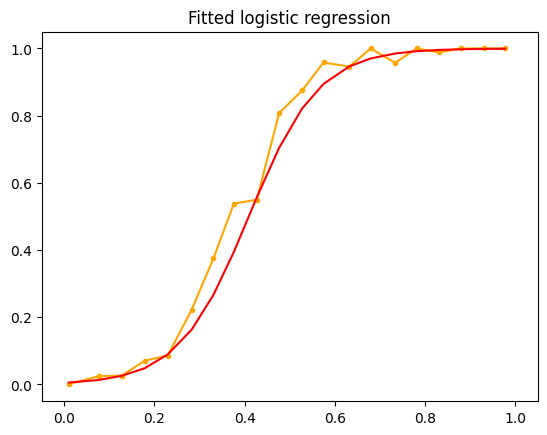

In [55]:
prob_pred_calib, alpha, beta = platt_scaling2(prob_pred, prob_true)
plt.plot([0, 1], [0, 1], alpha=0)
plt.plot(prob_pred, prob_true, marker='.', color='orange')
plt.plot(prob_pred, prob_pred_calib, color='red')
plt.title(f'Fitted logistic regression')
plt.show()

LogisticRegression()


C:\Users\wojciech.blachowski\Miniconda3\envs\calibration\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9324712643678161
LinearSVC()


C:\Users\wojciech.blachowski\Miniconda3\envs\calibration\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.9260057471264368
RandomForestClassifier()
0.9762931034482759
MLPClassifier()
0.985632183908046


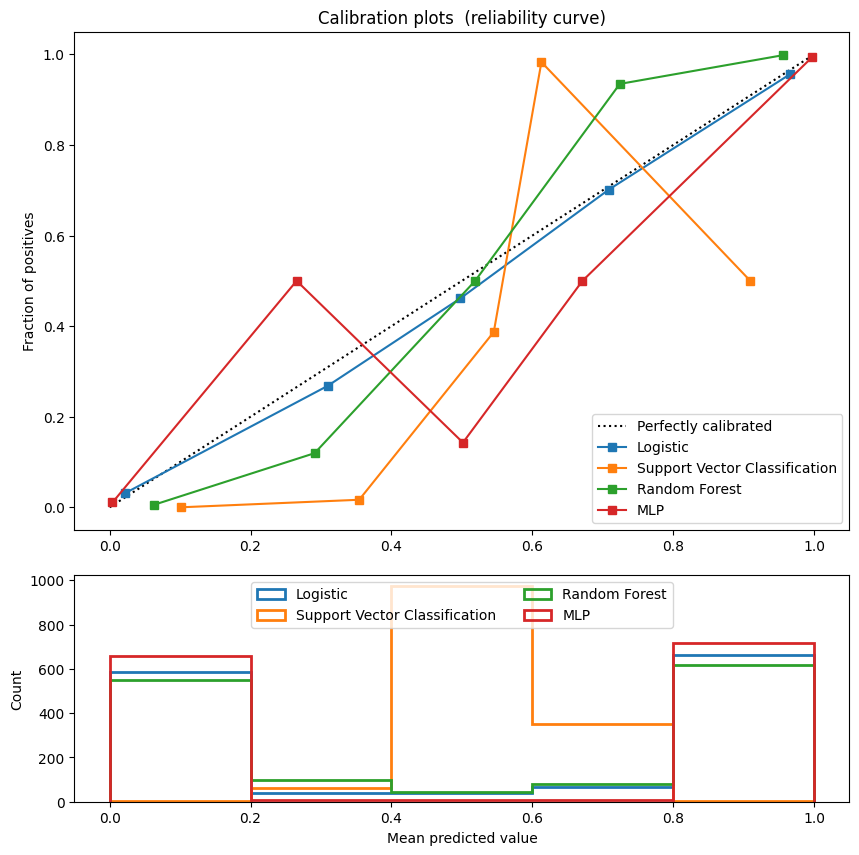

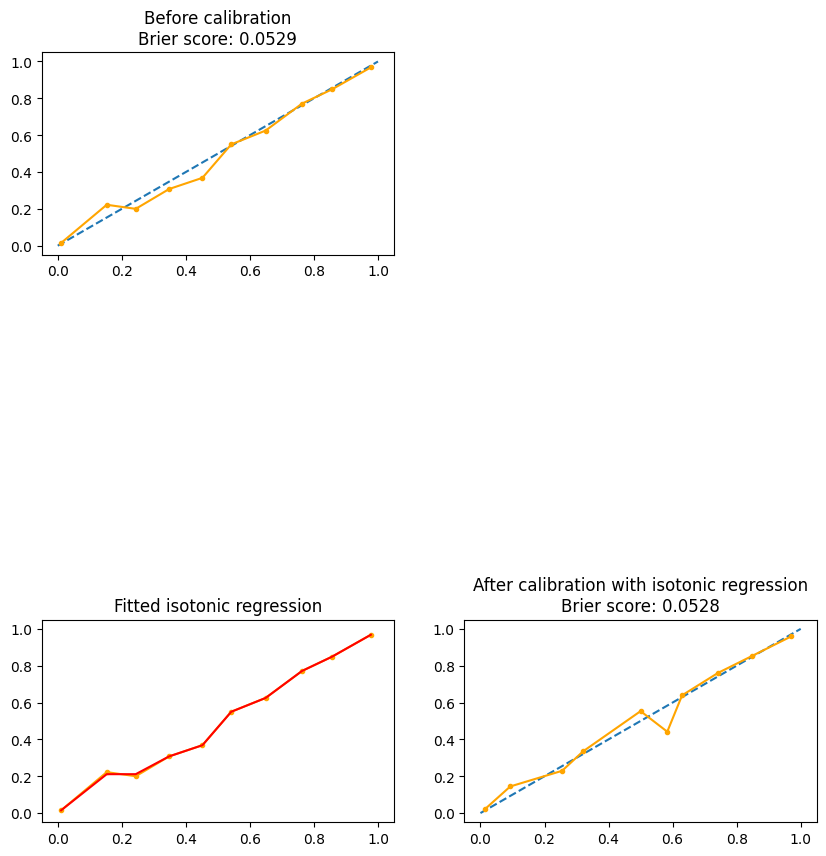

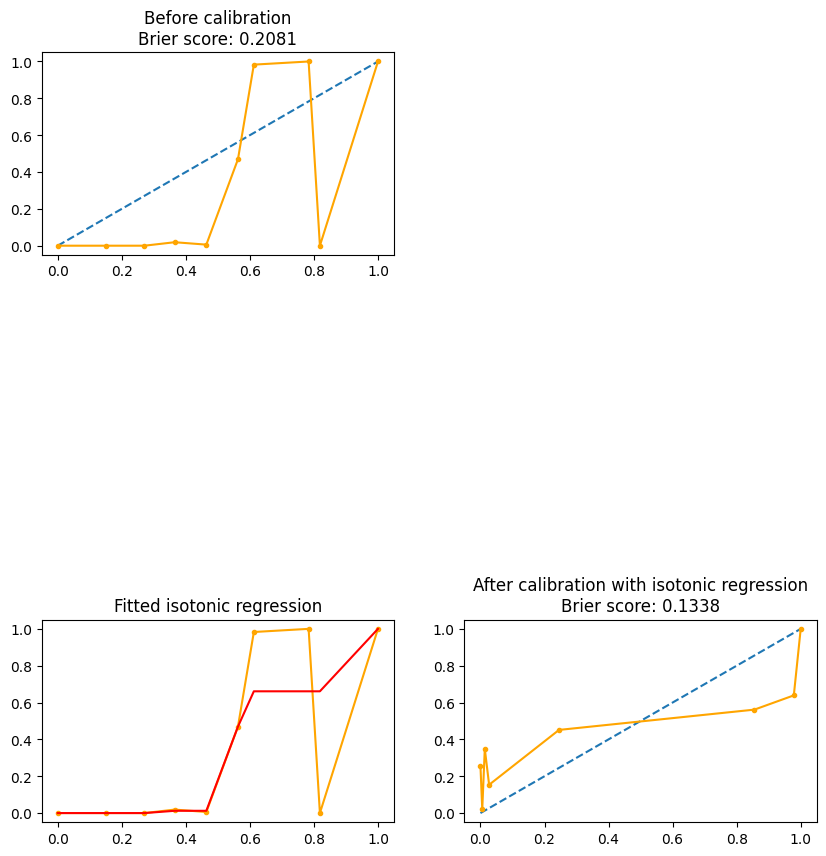

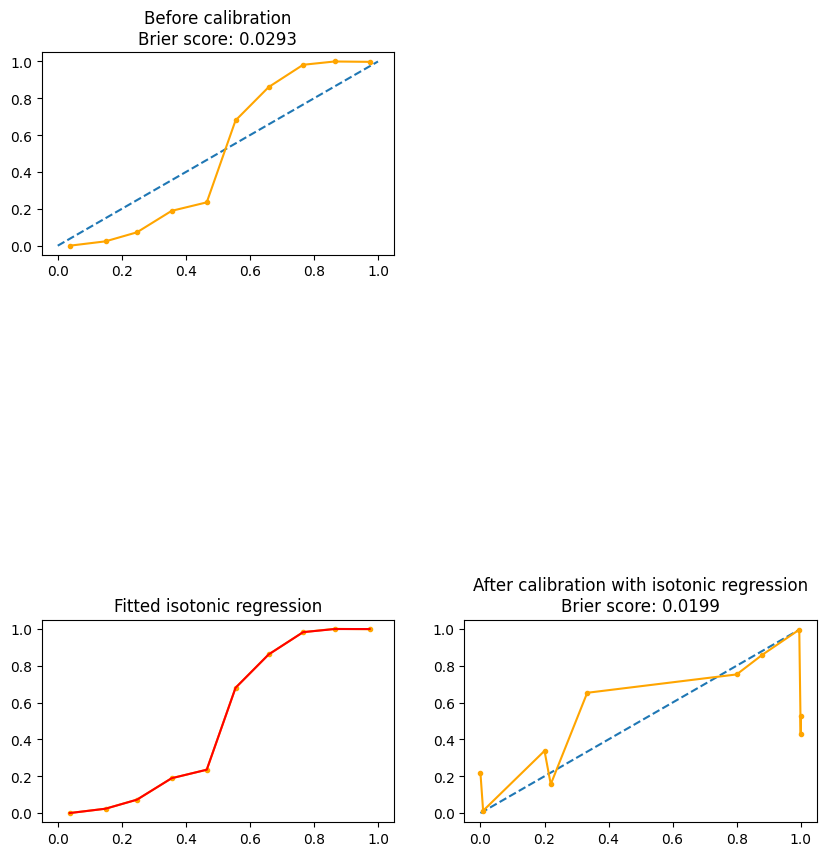

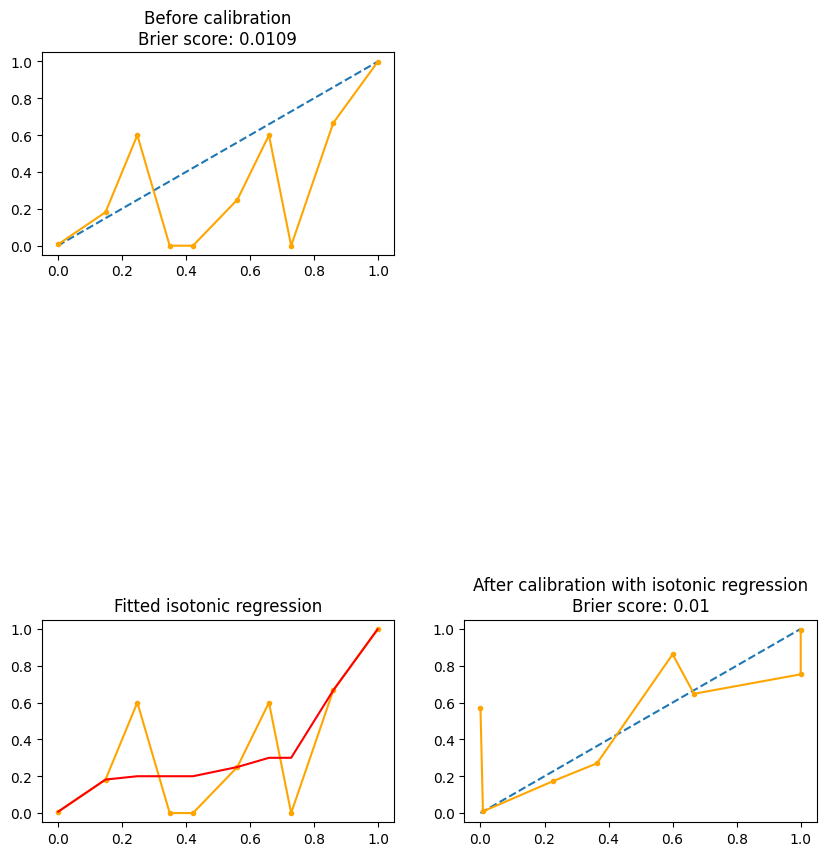

In [36]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.neural_network import MLPClassifier
# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier()
mlp = MLPClassifier()

# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
#                   (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                 (mlp, 'MLP')]:
    print(clf)
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=5)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=5, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
plt.show()

for clf, name in [(lr, 'Logistic'),
#                   (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest'),
                 (mlp, 'MLP')]:
    plot_calibration(clf, X_test, y_test)